# Definizione funzione di plot

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import ConfusionMatrixDisplay


def evaluator(history, model, test_generator):
    # Grafico di accuratezza (accuracy) di training e validation
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    # Grafico di perdita (loss) di training e validation
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()


    y_pred = model.predict(test_generator)
    
    y_true = test_generator.classes
    

    class_names = list(test_generator.class_indices.keys())

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    n_classes = test_generator.num_classes
    if n_classes > 2:
        # If multiclass classification, convert labels to one-hot encoded format
        y_true_one_hot = label_binarize(y_true, classes=np.arange(n_classes))
    else:
        # If binary classification, no need for one-hot encoding
        y_true_one_hot = y_true

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve and Confusion Matrix
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # ROC Curve
    ax[0].plot([0, 1], [0, 1], 'k--')  # Diagonal line (random classifier)
    for i in range(n_classes):
        ax[0].plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    ax[0].legend(loc="lower right")
    ax[0].grid()

    # Get the predicted classes by selecting the index of the highest probability
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Confusion Matrix
    im = ax[1].matshow(cm, cmap='Blues')
    ax[1].set_title('Confusion Matrix')
    plt.colorbar(im, ax=ax[1])
    ax[1].set_xticks(np.arange(len(class_names)))
    ax[1].set_yticks(np.arange(len(class_names)))
    ax[1].set_xticklabels(class_names, rotation=45)
    ax[1].set_yticklabels(class_names)
    ax[1].set_xlabel('Predicted label')
    ax[1].set_ylabel('True label')

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax[1].text(j, i, "{:.2f}".format(cm_normalized[i, j]), ha='center', va='center', color='black', fontsize=12)

    plt.tight_layout()
    plt.show()
    # Calculate and print classification report (precision, recall, F1-score, support)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))


# Load del set di immagini tramite ImageDataGenerator

In questa sezione viene usata ImageDataGenerator per caricare ed applicare delle trasformazioni al set di immagini al fine di riuscire ad incrementare il dataset (Data augmentation) nonchè permettere al modello di generalizzare più efficaciamente.

In [4]:
from keras.preprocessing.image import ImageDataGenerator

# Definisci il percorso della cartella contenente le immagini
train_directory = 'Data/train/'
validation_directory = 'Data/validation/'
test_directory = 'Data/test/'

# Definisci la dimensione delle immagini
image_size = (128, 128)


# Crea un oggetto ImageDataGenerator con le opportune configurazioni
train_generator = ImageDataGenerator(rescale=1./255, rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    )

validation_generator = ImageDataGenerator(rescale=1./255, rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    )

test_generator = ImageDataGenerator(rescale=1./255)

batch_size = 64

# Crea i generatori di dati per train set e test set utilizzando il metodo flow_from_directory
train_generator = train_generator.flow_from_directory(
    directory=train_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

validation_generator = validation_generator.flow_from_directory(
    directory=validation_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

test_generator = test_generator.flow_from_directory(
    directory=test_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

Found 1174 images belonging to 8 classes.
Found 240 images belonging to 8 classes.
Found 158 images belonging to 8 classes.


# Primo esperimento

Qui implementiamo uno modello CNN molto semplice al fine di ridurne la complessità e non andare in problematiche di overfitting.

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization

model = Sequential()
model.add(Conv2D(128, kernel_size = (3, 3), activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation = "softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 128)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 508032)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                32514112  
                                                                 
 dense_3 (Dense)             (None, 8)                 520       
                                                                 
Total params: 32,518,216
Trainable params: 32,518,216
Non-trainable params: 0
__________________________________________

In [8]:
history = model.fit(
    train_generator,
    epochs = 25,
    validation_data = validation_generator,
)

Epoch 1/25
19/19 [==============================] - 26s 1s/step - loss: 10.1711 - accuracy: 0.1823 - val_loss: 1.9205 - val_accuracy: 0.2250
Epoch 2/25
19/19 [==============================] - 22s 1s/step - loss: 1.5053 - accuracy: 0.4787 - val_loss: 1.4907 - val_accuracy: 0.5208
Epoch 3/25
19/19 [==============================] - 23s 1s/step - loss: 1.0647 - accuracy: 0.6814 - val_loss: 1.0719 - val_accuracy: 0.6750
Epoch 4/25
19/19 [==============================] - 23s 1s/step - loss: 0.8652 - accuracy: 0.7547 - val_loss: 1.0619 - val_accuracy: 0.6625
Epoch 5/25
19/19 [==============================] - 23s 1s/step - loss: 0.7732 - accuracy: 0.7615 - val_loss: 0.9878 - val_accuracy: 0.6667
Epoch 6/25
19/19 [==============================] - 23s 1s/step - loss: 0.7560 - accuracy: 0.7521 - val_loss: 1.0278 - val_accuracy: 0.6833
Epoch 7/25
19/19 [==============================] - 23s 1s/step - loss: 0.6532 - accuracy: 0.8007 - val_loss: 0.7825 - val_accuracy: 0.7667
Epoch 8/25
19/19 [=

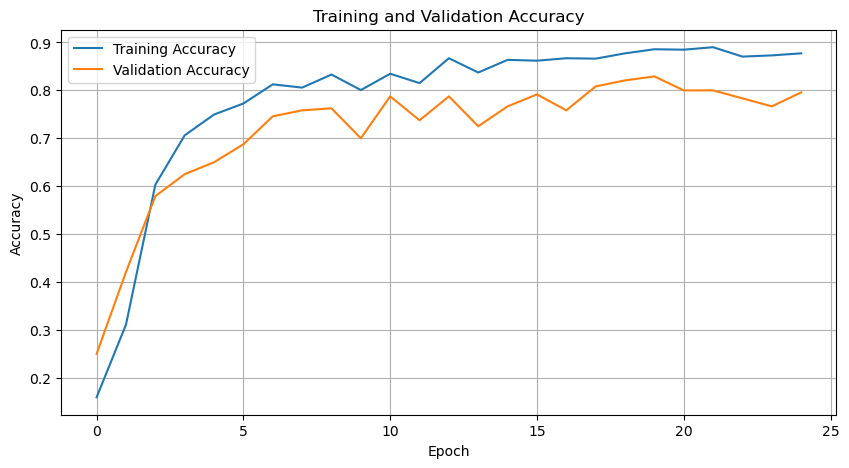

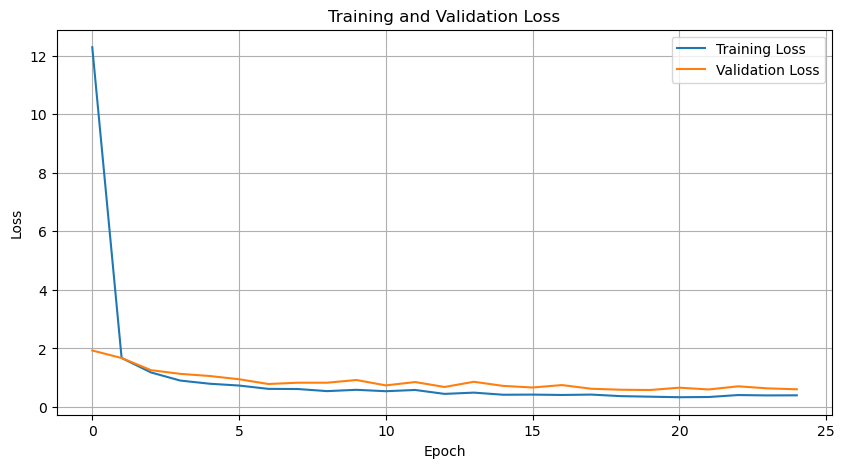

3/3 [==============================] - 1s 193ms/step


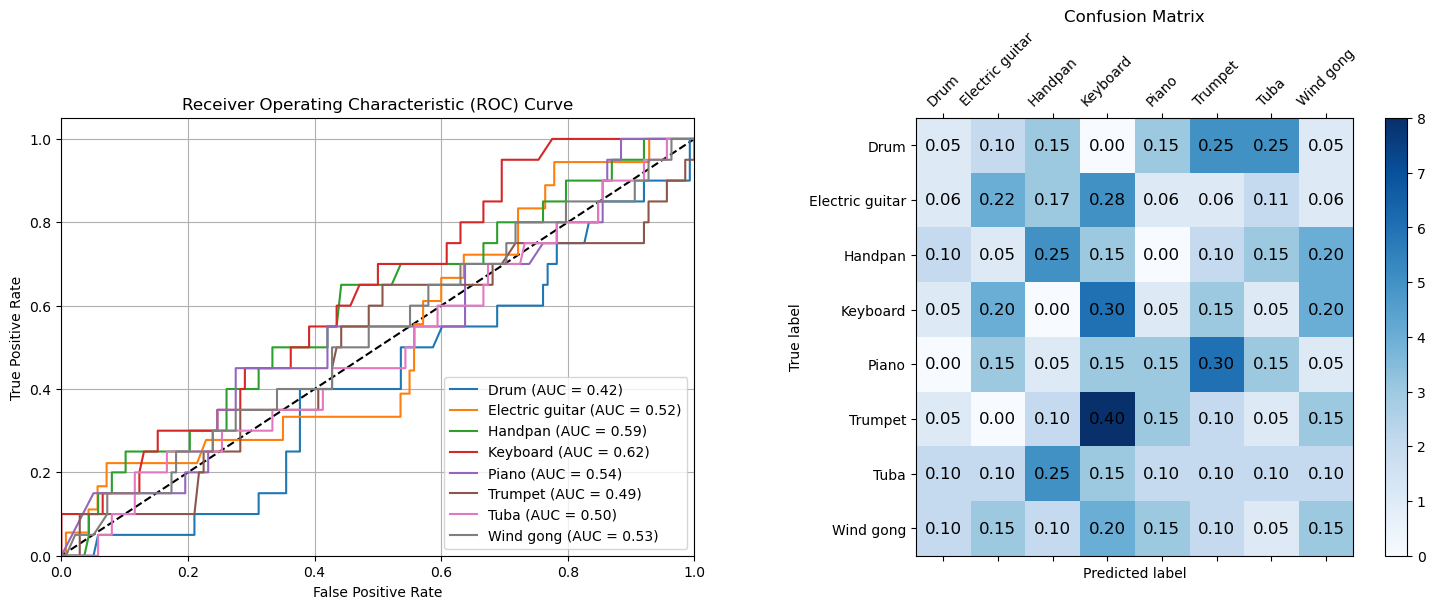


Classification Report:
                 precision    recall  f1-score   support

           Drum       0.10      0.05      0.07        20
Electric guitar       0.21      0.22      0.22        18
        Handpan       0.24      0.25      0.24        20
       Keyboard       0.19      0.30      0.23        20
          Piano       0.19      0.15      0.17        20
        Trumpet       0.09      0.10      0.09        20
           Tuba       0.11      0.10      0.11        20
      Wind gong       0.16      0.15      0.15        20

       accuracy                           0.16       158
      macro avg       0.16      0.17      0.16       158
   weighted avg       0.16      0.16      0.16       158



In [83]:
evaluator(history, model, test_generator)

In [9]:
model.save('modello_primo_esperimento.h5')

# Secondo esperimento

Qui aggiungiamo un altro strato di convoluzione e MaxPooling al fine di permettere al modello di convergere meglio. Questa decisione è stata presa sulla base dei risultati precedenti in cui verso le ultime epoche il modello ha iniziato a fare fatica a convergere ulteriormente.

In [84]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization

model = Sequential()
model.add(Conv2D(128, kernel_size = (3, 3), activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation = "softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 63, 63, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 61, 61, 64)        73792     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 flatten_21 (Flatten)        (None, 57600)             0         
                                                                 
 dense_48 (Dense)            (None, 64)              

In [85]:
history = model.fit(
    train_generator,
    epochs = 25,
    validation_data = validation_generator,
)

Epoch 1/25
19/19 [==============================] - 31s 2s/step - loss: 2.2662 - accuracy: 0.1431 - val_loss: 1.9425 - val_accuracy: 0.1625
Epoch 2/25
19/19 [==============================] - 29s 2s/step - loss: 1.5320 - accuracy: 0.4233 - val_loss: 1.5820 - val_accuracy: 0.3833
Epoch 3/25
19/19 [==============================] - 29s 2s/step - loss: 1.2052 - accuracy: 0.5860 - val_loss: 1.3755 - val_accuracy: 0.5208
Epoch 4/25
19/19 [==============================] - 29s 1s/step - loss: 1.0361 - accuracy: 0.6610 - val_loss: 1.2058 - val_accuracy: 0.5542
Epoch 5/25
19/19 [==============================] - 29s 2s/step - loss: 0.8561 - accuracy: 0.7232 - val_loss: 1.2498 - val_accuracy: 0.5750
Epoch 6/25
19/19 [==============================] - 27s 1s/step - loss: 0.7604 - accuracy: 0.7521 - val_loss: 0.9902 - val_accuracy: 0.7083
Epoch 7/25
19/19 [==============================] - 27s 1s/step - loss: 0.6985 - accuracy: 0.7768 - val_loss: 0.8925 - val_accuracy: 0.7167
Epoch 8/25
19/19 [==

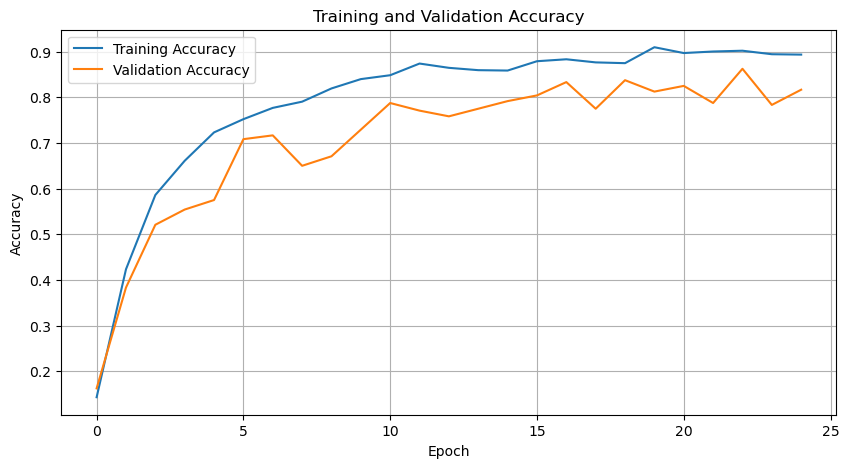

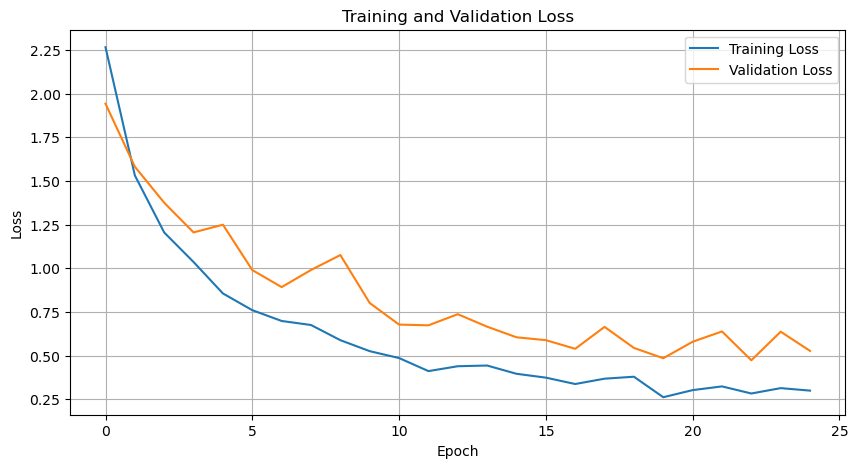

3/3 [==============================] - 1s 235ms/step


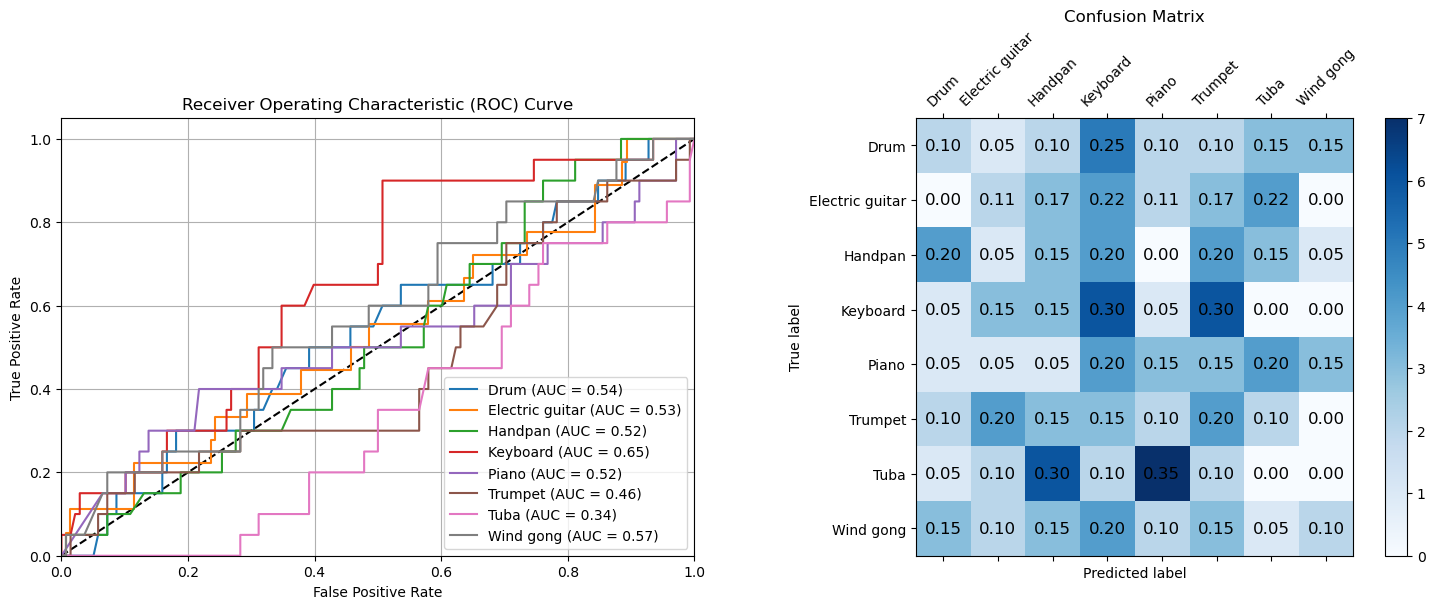


Classification Report:
                 precision    recall  f1-score   support

           Drum       0.14      0.10      0.12        20
Electric guitar       0.12      0.11      0.12        18
        Handpan       0.12      0.15      0.14        20
       Keyboard       0.19      0.30      0.23        20
          Piano       0.16      0.15      0.15        20
        Trumpet       0.15      0.20      0.17        20
           Tuba       0.00      0.00      0.00        20
      Wind gong       0.22      0.10      0.14        20

       accuracy                           0.14       158
      macro avg       0.14      0.14      0.13       158
   weighted avg       0.14      0.14      0.13       158



In [86]:
evaluator(history, model, test_generator)

# Terzo esperimento

Qui viene aggiunto un layer di BatchNormalization che tuttavia non ha buoni risultati (il modello non riesce a generalizzare)

In [87]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization

model = Sequential()
model.add(Conv2D(128, kernel_size = (3, 3), activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation = "softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 63, 63, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 61, 61, 64)        73792     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Batc  (None, 30, 30, 64)       256       
 hNormalization)                                                 
                                                     

In [88]:
history = model.fit(
    train_generator,
    epochs = 25,
    validation_data = validation_generator,
)

Epoch 1/25
19/19 [==============================] - 42s 2s/step - loss: 1.5492 - accuracy: 0.5801 - val_loss: 2.2133 - val_accuracy: 0.3875
Epoch 2/25
19/19 [==============================] - 39s 2s/step - loss: 0.7902 - accuracy: 0.7530 - val_loss: 2.6838 - val_accuracy: 0.1583
Epoch 3/25
19/19 [==============================] - 39s 2s/step - loss: 0.7929 - accuracy: 0.7598 - val_loss: 2.6156 - val_accuracy: 0.2333
Epoch 4/25
19/19 [==============================] - 39s 2s/step - loss: 0.6436 - accuracy: 0.8092 - val_loss: 1.8718 - val_accuracy: 0.4083
Epoch 5/25
19/19 [==============================] - 40s 2s/step - loss: 0.4790 - accuracy: 0.8535 - val_loss: 3.5075 - val_accuracy: 0.2708
Epoch 6/25
19/19 [==============================] - 39s 2s/step - loss: 0.4766 - accuracy: 0.8705 - val_loss: 3.3293 - val_accuracy: 0.2583
Epoch 7/25
19/19 [==============================] - 38s 2s/step - loss: 0.4025 - accuracy: 0.8731 - val_loss: 1.7670 - val_accuracy: 0.2458
Epoch 8/25
19/19 [==

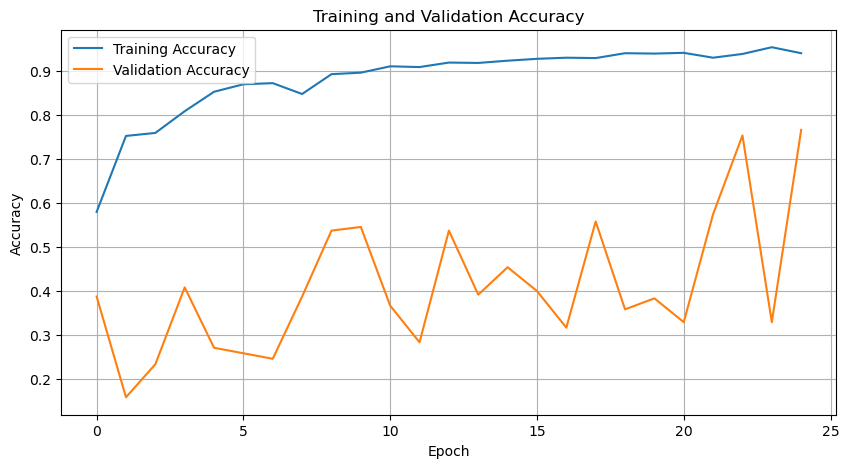

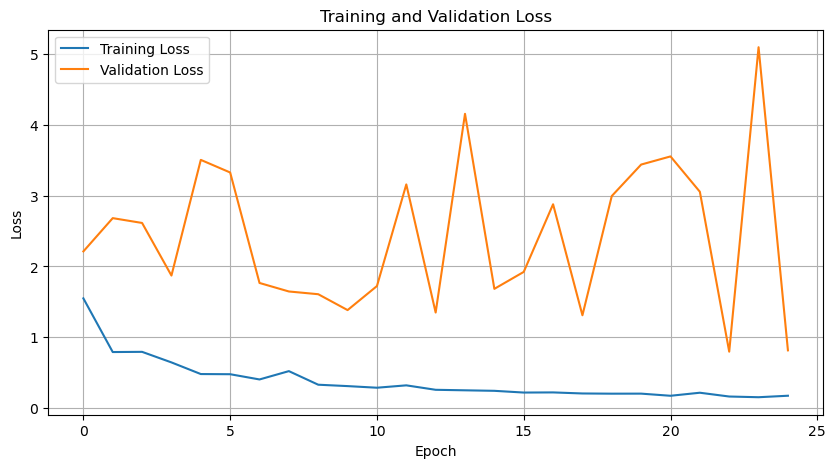

3/3 [==============================] - 2s 474ms/step


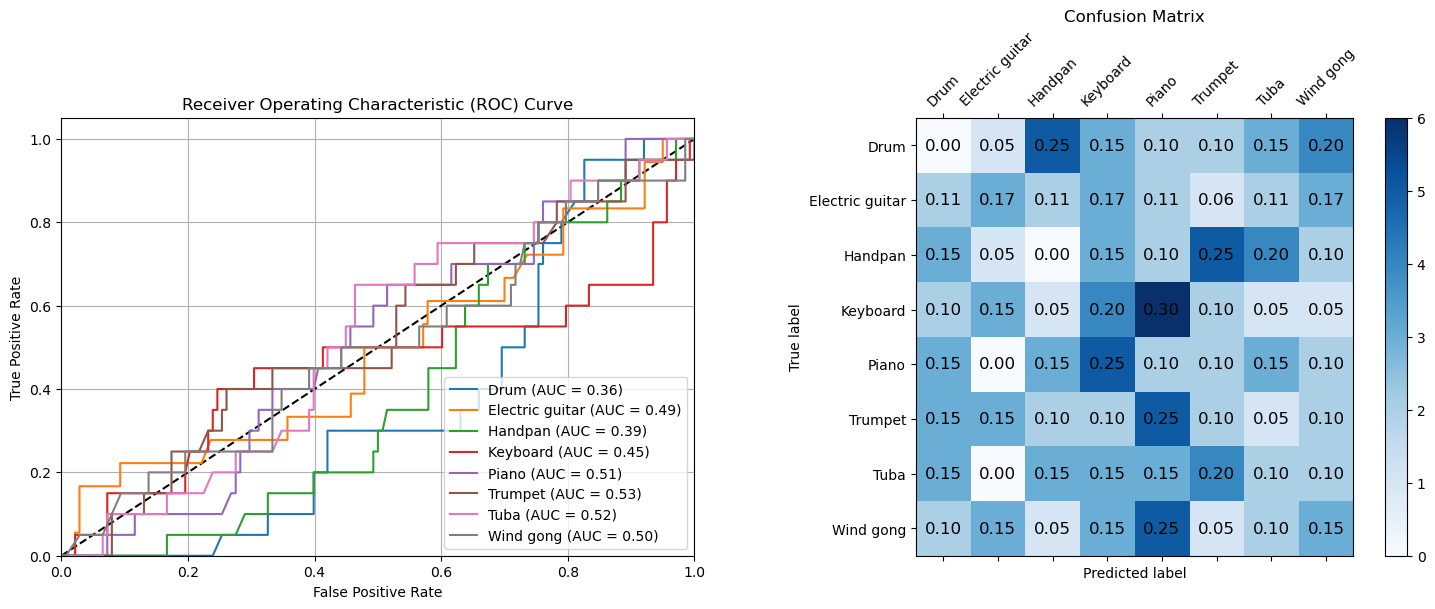


Classification Report:
                 precision    recall  f1-score   support

           Drum       0.00      0.00      0.00        20
Electric guitar       0.21      0.17      0.19        18
        Handpan       0.00      0.00      0.00        20
       Keyboard       0.15      0.20      0.17        20
          Piano       0.07      0.10      0.09        20
        Trumpet       0.11      0.10      0.10        20
           Tuba       0.11      0.10      0.11        20
      Wind gong       0.16      0.15      0.15        20

       accuracy                           0.10       158
      macro avg       0.10      0.10      0.10       158
   weighted avg       0.10      0.10      0.10       158



In [89]:
evaluator(history, model, test_generator)

# Quarto esperimento

In [90]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization

model = Sequential()
model.add(Conv2D(128, kernel_size = (3, 3), activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation = "softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 63, 63, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 61, 61, 64)        73792     
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 14, 14, 64)     

In [91]:
history = model.fit(
    train_generator,
    epochs = 25,
    validation_data = validation_generator,
)

Epoch 1/25
19/19 [==============================] - 40s 2s/step - loss: 1.2236 - accuracy: 0.5920 - val_loss: 2.1955 - val_accuracy: 0.2667
Epoch 2/25
19/19 [==============================] - 38s 2s/step - loss: 0.6663 - accuracy: 0.7853 - val_loss: 2.3700 - val_accuracy: 0.2417
Epoch 3/25
19/19 [==============================] - 38s 2s/step - loss: 0.4958 - accuracy: 0.8458 - val_loss: 2.8546 - val_accuracy: 0.2375
Epoch 4/25
19/19 [==============================] - 38s 2s/step - loss: 0.4933 - accuracy: 0.8467 - val_loss: 2.5710 - val_accuracy: 0.2500
Epoch 5/25
19/19 [==============================] - 37s 2s/step - loss: 0.3797 - accuracy: 0.8790 - val_loss: 1.5777 - val_accuracy: 0.4292
Epoch 6/25
19/19 [==============================] - 38s 2s/step - loss: 0.3194 - accuracy: 0.8935 - val_loss: 4.3569 - val_accuracy: 0.2333
Epoch 7/25
19/19 [==============================] - 38s 2s/step - loss: 0.3700 - accuracy: 0.8952 - val_loss: 1.5563 - val_accuracy: 0.3542
Epoch 8/25
19/19 [==

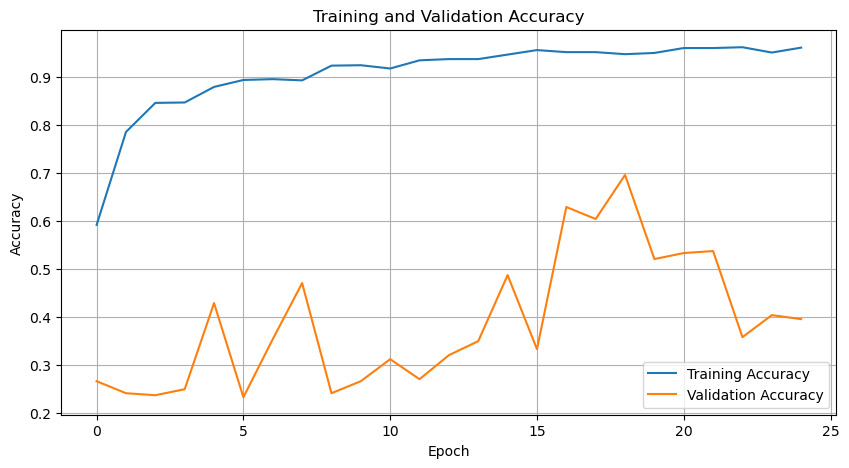

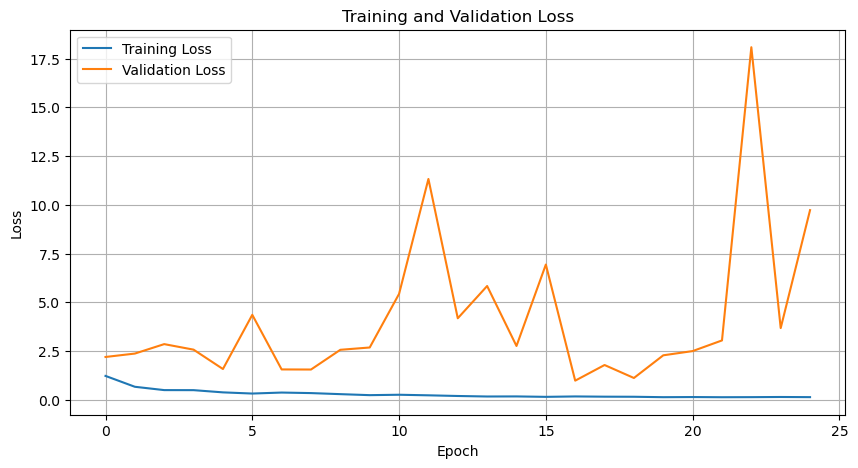

3/3 [==============================] - 2s 472ms/step


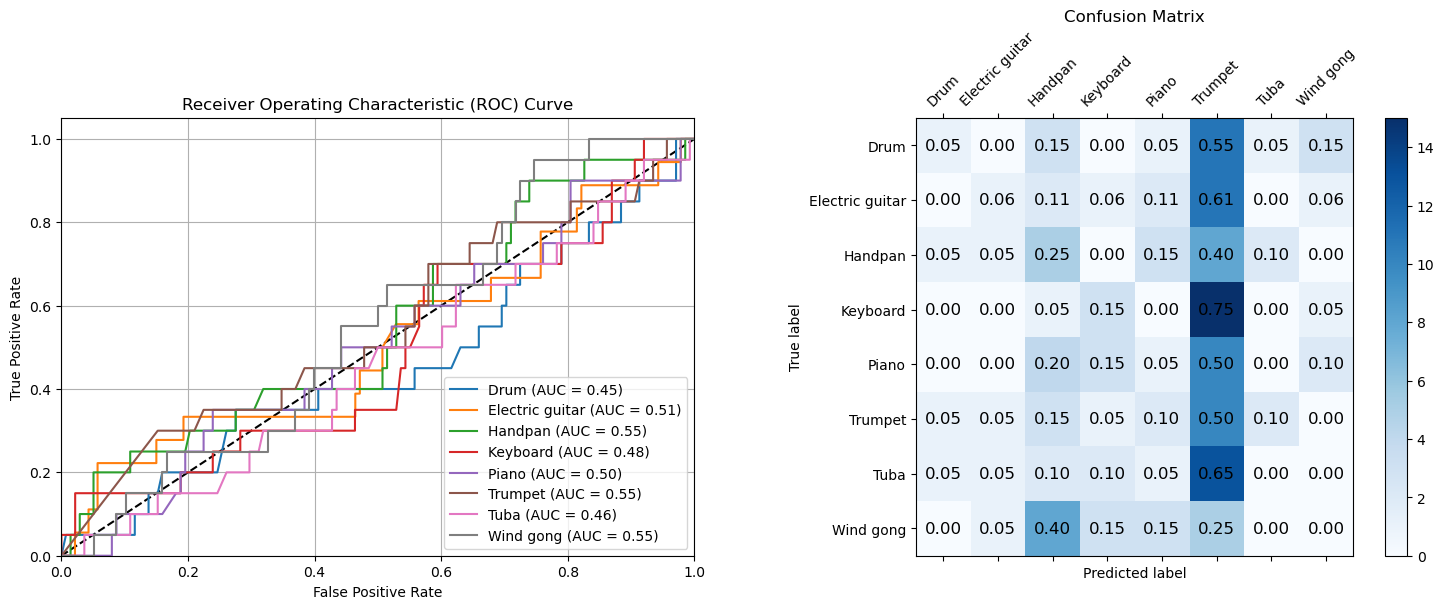


Classification Report:
                 precision    recall  f1-score   support

           Drum       0.25      0.05      0.08        20
Electric guitar       0.20      0.06      0.09        18
        Handpan       0.18      0.25      0.21        20
       Keyboard       0.23      0.15      0.18        20
          Piano       0.08      0.05      0.06        20
        Trumpet       0.12      0.50      0.19        20
           Tuba       0.00      0.00      0.00        20
      Wind gong       0.00      0.00      0.00        20

       accuracy                           0.13       158
      macro avg       0.13      0.13      0.10       158
   weighted avg       0.13      0.13      0.10       158



In [92]:
evaluator(history, model, test_generator)

# Quinto esperimento

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization

model = Sequential()
model.add(Conv2D(128, kernel_size = (3, 3), activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation = "softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 63, 63, 128)      0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 128)       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 61, 61, 64)        73792     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 30, 30, 64)      

In [ ]:
history = model.fit(
    train_generator,
    epochs = 25,
    validation_data = validation_generator,
)

Epoch 1/25
19/19 [==============================] - 40s 2s/step - loss: 2.0593 - accuracy: 0.1917 - val_loss: 2.0752 - val_accuracy: 0.1458
Epoch 2/25
19/19 [==============================] - 33s 2s/step - loss: 1.9685 - accuracy: 0.2334 - val_loss: 2.0375 - val_accuracy: 0.2375
Epoch 3/25
19/19 [==============================] - 33s 2s/step - loss: 1.7711 - accuracy: 0.3825 - val_loss: 1.8294 - val_accuracy: 0.3792
Epoch 4/25
19/19 [==============================] - 34s 2s/step - loss: 1.5204 - accuracy: 0.4497 - val_loss: 1.5953 - val_accuracy: 0.5000
Epoch 5/25
19/19 [==============================] - 34s 2s/step - loss: 1.2228 - accuracy: 0.6090 - val_loss: 1.3548 - val_accuracy: 0.5250
Epoch 6/25
19/19 [==============================] - 34s 2s/step - loss: 1.1383 - accuracy: 0.6235 - val_loss: 1.4387 - val_accuracy: 0.4042
Epoch 7/25
19/19 [==============================] - 34s 2s/step - loss: 1.0387 - accuracy: 0.6601 - val_loss: 1.2892 - val_accuracy: 0.5583
Epoch 8/25
19/19 [==

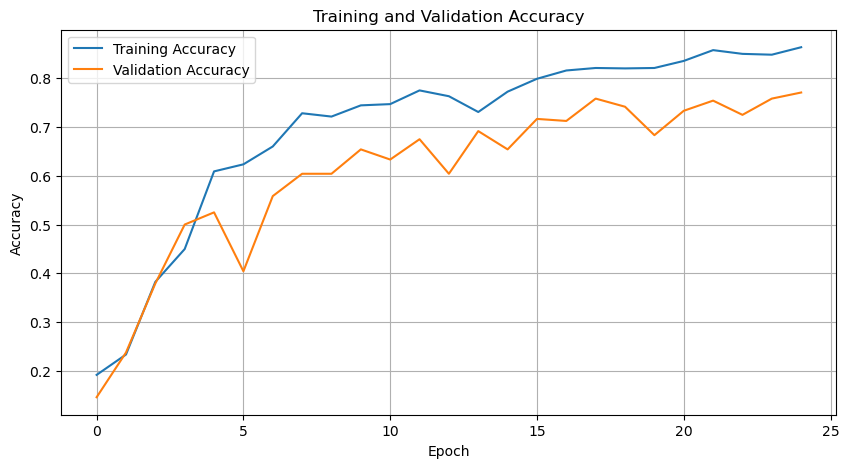

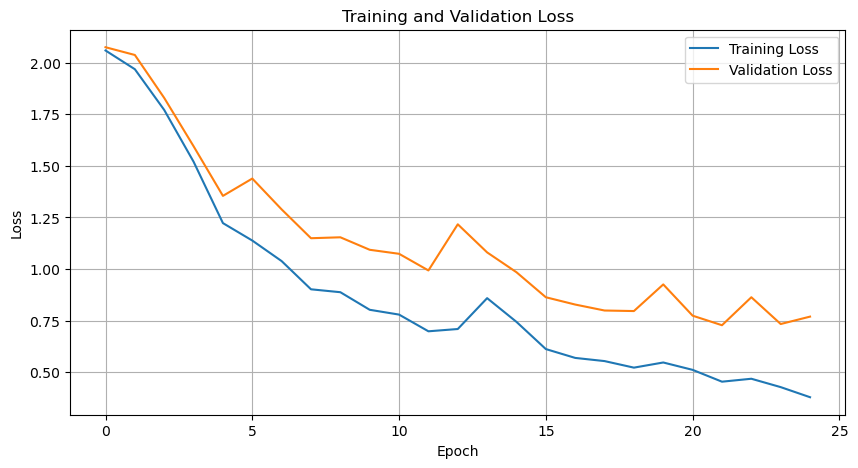

3/3 [==============================] - 2s 584ms/step


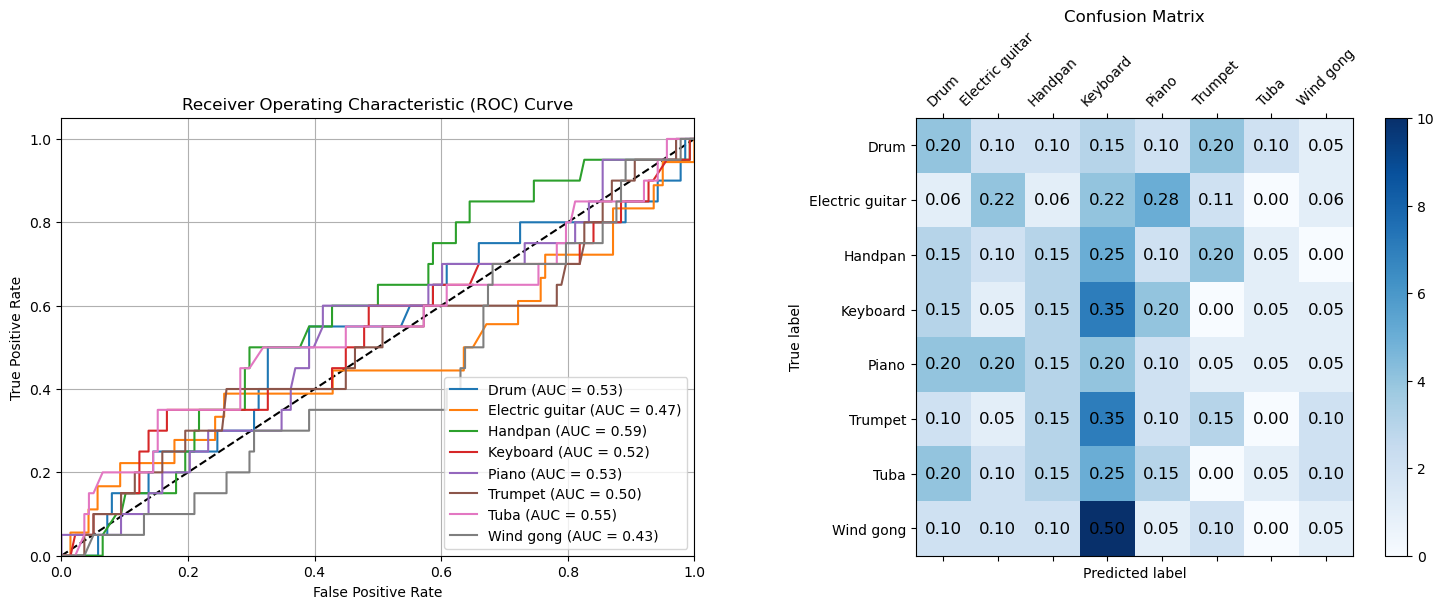


Classification Report:
                 precision    recall  f1-score   support

           Drum       0.17      0.20      0.19        20
Electric guitar       0.22      0.22      0.22        18
        Handpan       0.15      0.15      0.15        20
       Keyboard       0.16      0.35      0.22        20
          Piano       0.10      0.10      0.10        20
        Trumpet       0.19      0.15      0.17        20
           Tuba       0.17      0.05      0.08        20
      Wind gong       0.11      0.05      0.07        20

       accuracy                           0.16       158
      macro avg       0.16      0.16      0.15       158
   weighted avg       0.16      0.16      0.15       158



In [ ]:
evaluator(history, model, test_generator)

# Sesto esperimento

In [96]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization

model = Sequential()
model.add(Conv2D(256, kernel_size = (3, 3), activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation = "softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 126, 126, 256)     7168      
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 63, 63, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 61, 61, 128)       295040    
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 30, 30, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 28, 28, 128)       147584    
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 14, 14, 128)    

In [97]:
history = model.fit(
    train_generator,
    epochs = 25,
    validation_data = validation_generator,
)

Epoch 1/25
19/19 [==============================] - 76s 4s/step - loss: 2.0294 - accuracy: 0.1763 - val_loss: 2.0395 - val_accuracy: 0.2375
Epoch 2/25
19/19 [==============================] - 74s 4s/step - loss: 1.8329 - accuracy: 0.3092 - val_loss: 1.9677 - val_accuracy: 0.1500
Epoch 3/25
19/19 [==============================] - 73s 4s/step - loss: 1.6607 - accuracy: 0.3543 - val_loss: 1.6778 - val_accuracy: 0.2833
Epoch 4/25
19/19 [==============================] - 73s 4s/step - loss: 1.3708 - accuracy: 0.4847 - val_loss: 1.5260 - val_accuracy: 0.4750
Epoch 5/25
19/19 [==============================] - 74s 4s/step - loss: 1.2180 - accuracy: 0.5818 - val_loss: 1.4605 - val_accuracy: 0.4458
Epoch 6/25
19/19 [==============================] - 73s 4s/step - loss: 1.3167 - accuracy: 0.5213 - val_loss: 1.5203 - val_accuracy: 0.3833
Epoch 7/25
19/19 [==============================] - 73s 4s/step - loss: 1.1315 - accuracy: 0.5963 - val_loss: 1.3131 - val_accuracy: 0.5167
Epoch 8/25
19/19 [==

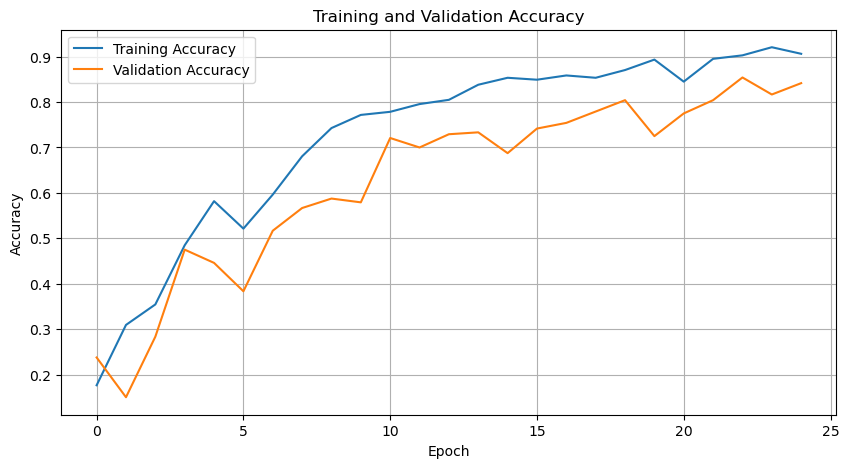

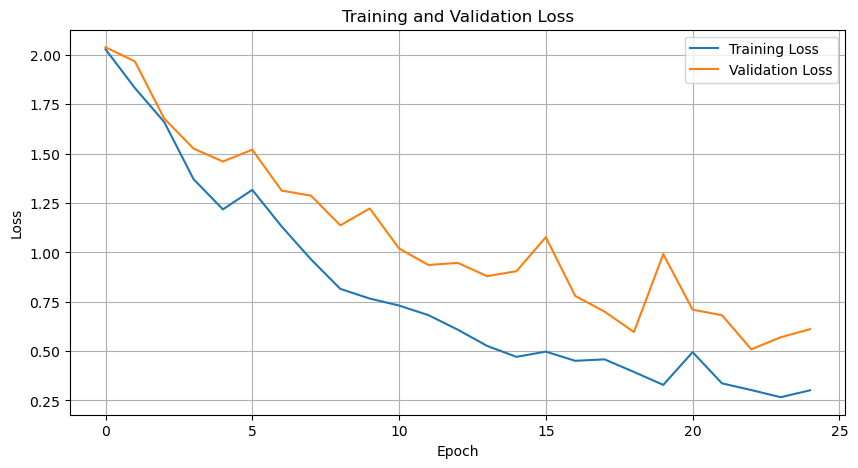

4/4 [==============================] - 5s 1s/step


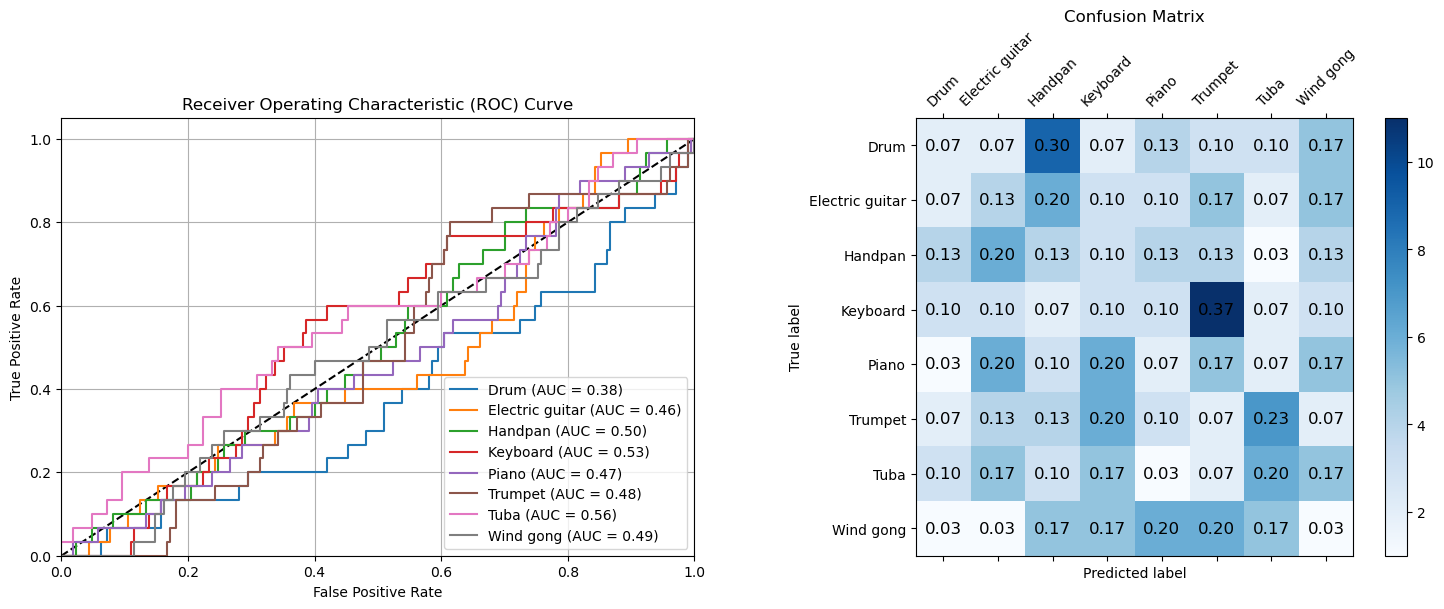


Classification Report:
                 precision    recall  f1-score   support

           Drum       0.11      0.07      0.08        30
Electric guitar       0.13      0.13      0.13        30
        Handpan       0.11      0.13      0.12        30
       Keyboard       0.09      0.10      0.10        30
          Piano       0.08      0.07      0.07        30
        Trumpet       0.05      0.07      0.06        30
           Tuba       0.21      0.20      0.21        30
      Wind gong       0.03      0.03      0.03        30

       accuracy                           0.10       240
      macro avg       0.10      0.10      0.10       240
   weighted avg       0.10      0.10      0.10       240



In [98]:
evaluator(history, model, validation_generator)

# Settimo esperimento

In [99]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization

model = Sequential()
model.add(Conv2D(256, kernel_size = (3, 3), activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation = "softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 126, 126, 256)     7168      
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 63, 63, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 61, 61, 128)       295040    
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 30, 30, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 28, 28, 64)        73792     
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 14, 14, 64)     

In [100]:
history = model.fit(
    train_generator,
    epochs = 25,
    validation_data = validation_generator,
)

Epoch 1/25
19/19 [==============================] - 61s 3s/step - loss: 2.0120 - accuracy: 0.2002 - val_loss: 2.0171 - val_accuracy: 0.1833
Epoch 2/25
19/19 [==============================] - 59s 3s/step - loss: 1.6464 - accuracy: 0.3995 - val_loss: 1.7148 - val_accuracy: 0.3625
Epoch 3/25
19/19 [==============================] - 59s 3s/step - loss: 1.2493 - accuracy: 0.5826 - val_loss: 1.4063 - val_accuracy: 0.5250
Epoch 4/25
19/19 [==============================] - 59s 3s/step - loss: 1.1051 - accuracy: 0.6482 - val_loss: 1.3485 - val_accuracy: 0.5083
Epoch 5/25
19/19 [==============================] - 59s 3s/step - loss: 0.9713 - accuracy: 0.6814 - val_loss: 1.2473 - val_accuracy: 0.5917
Epoch 6/25
19/19 [==============================] - 59s 3s/step - loss: 0.9145 - accuracy: 0.7019 - val_loss: 1.2252 - val_accuracy: 0.5583
Epoch 7/25
19/19 [==============================] - 59s 3s/step - loss: 0.8343 - accuracy: 0.7368 - val_loss: 1.0546 - val_accuracy: 0.6458
Epoch 8/25
19/19 [==

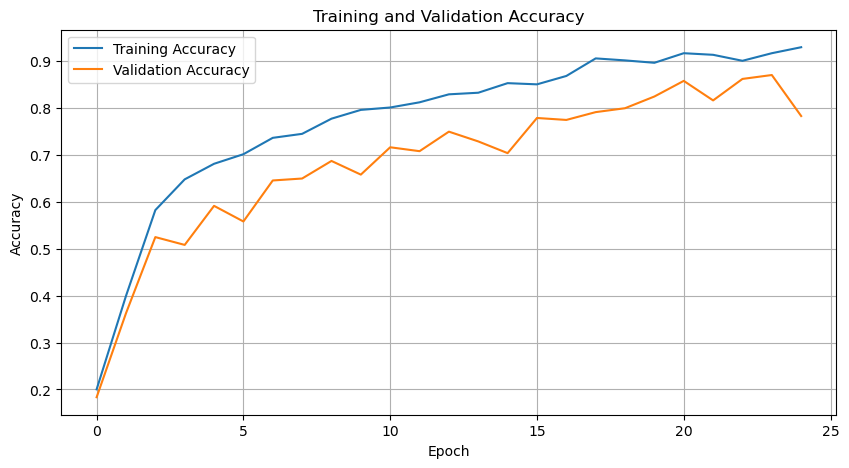

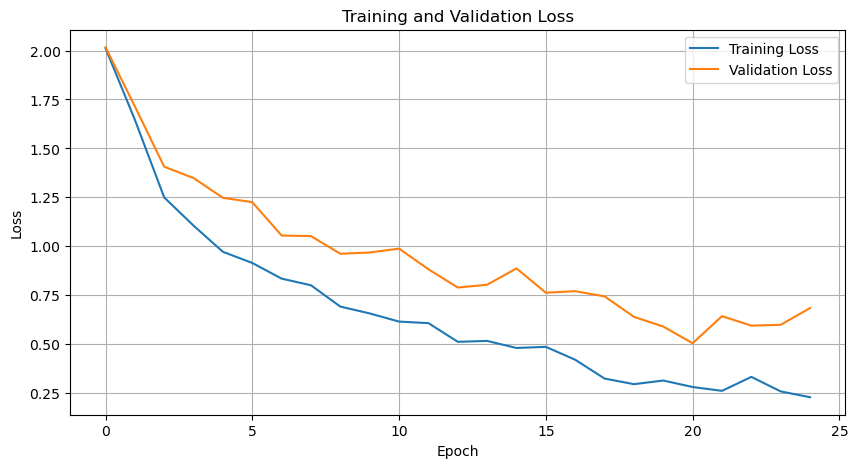

3/3 [==============================] - 2s 565ms/step


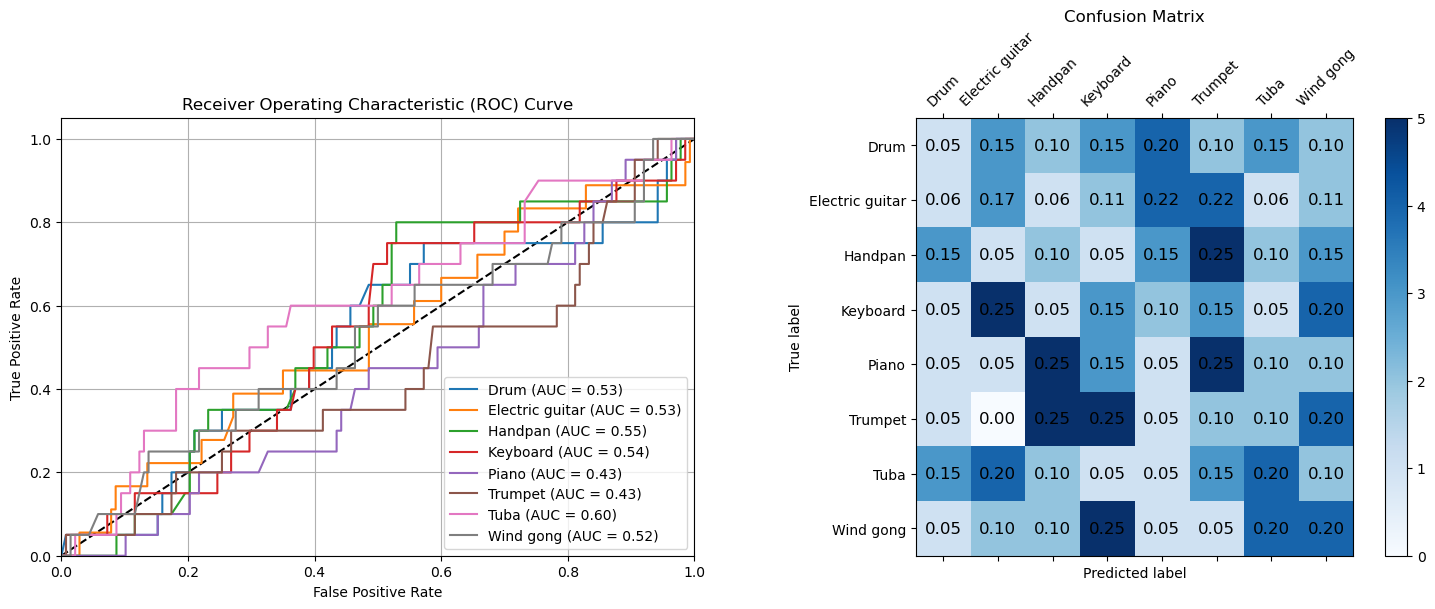


Classification Report:
                 precision    recall  f1-score   support

           Drum       0.08      0.05      0.06        20
Electric guitar       0.16      0.17      0.16        18
        Handpan       0.10      0.10      0.10        20
       Keyboard       0.13      0.15      0.14        20
          Piano       0.06      0.05      0.05        20
        Trumpet       0.08      0.10      0.09        20
           Tuba       0.21      0.20      0.21        20
      Wind gong       0.17      0.20      0.19        20

       accuracy                           0.13       158
      macro avg       0.12      0.13      0.12       158
   weighted avg       0.12      0.13      0.12       158



In [101]:
evaluator(history, model, test_generator)

# Ottavo esperimento facendo fine tuning con il modello pre-addestrato EfficientNetB0

Qui proviamo il modello CNN della google EfficientNetB0, il chè, rivelandosi però troppo potente per il problema di classificazione affrontato, va in overfitting.

In [102]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB3

efficient_net = EfficientNetB3(
    weights='imagenet',
    input_shape=(128,128,3),
    include_top=False,
    pooling='max',
)

model = Sequential()
model.add(efficient_net)
model.add(Dense(units = 8, activation='softmax'))
model.summary()

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 dense_63 (Dense)            (None, 8)                 12296     
                                                                 
Total params: 10,795,831
Trainable params: 10,708,528
Non-trainable params: 87,303
_________________________________________________________________


In [103]:
history = model.fit(
    train_generator,
    epochs = 25,
    validation_data = validation_generator,
)

Epoch 1/25
19/19 [==============================] - 130s 5s/step - loss: 0.6031 - accuracy: 0.8595 - val_loss: 2.3796 - val_accuracy: 0.1250
Epoch 2/25
19/19 [==============================] - 101s 5s/step - loss: 0.0998 - accuracy: 0.9779 - val_loss: 2.4688 - val_accuracy: 0.1250
Epoch 3/25
19/19 [==============================] - 102s 5s/step - loss: 0.0864 - accuracy: 0.9779 - val_loss: 2.1869 - val_accuracy: 0.1250
Epoch 4/25
19/19 [==============================] - 101s 5s/step - loss: 0.0596 - accuracy: 0.9821 - val_loss: 2.1786 - val_accuracy: 0.1250
Epoch 5/25
19/19 [==============================] - 101s 5s/step - loss: 0.1020 - accuracy: 0.9753 - val_loss: 2.3093 - val_accuracy: 0.1708
Epoch 6/25
19/19 [==============================] - 101s 5s/step - loss: 0.0262 - accuracy: 0.9915 - val_loss: 2.5571 - val_accuracy: 0.1250
Epoch 7/25
19/19 [==============================] - 101s 5s/step - loss: 0.0528 - accuracy: 0.9915 - val_loss: 2.6221 - val_accuracy: 0.1250
Epoch 8/25
19

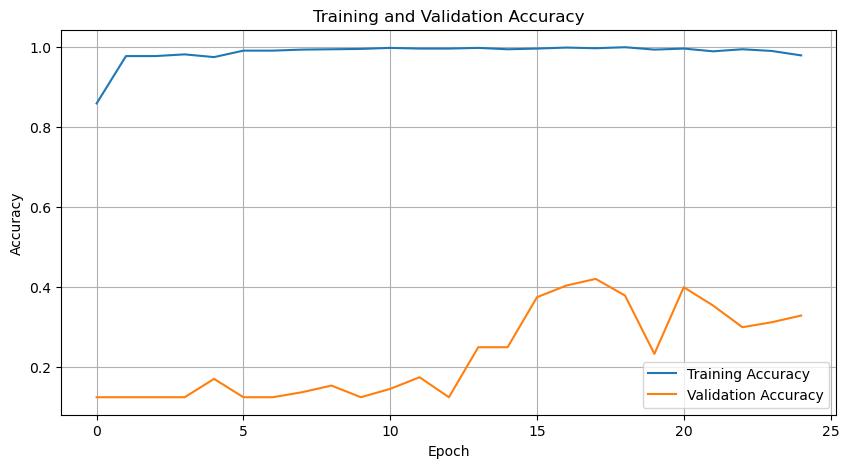

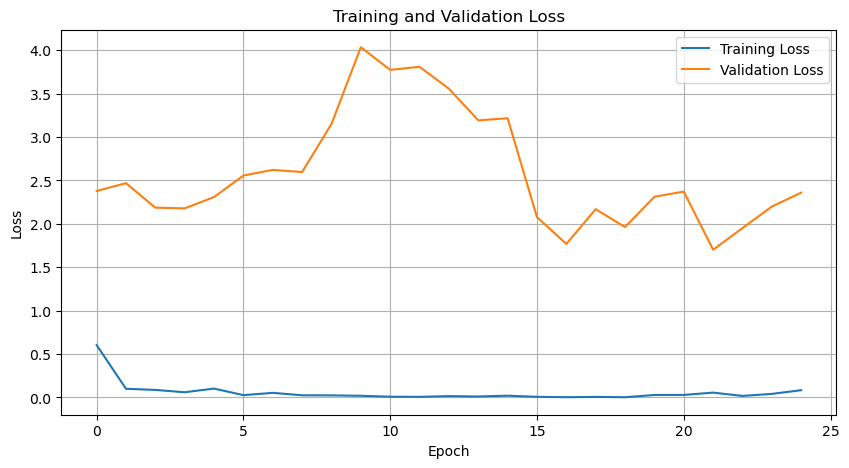

3/3 [==============================] - 5s 787ms/step


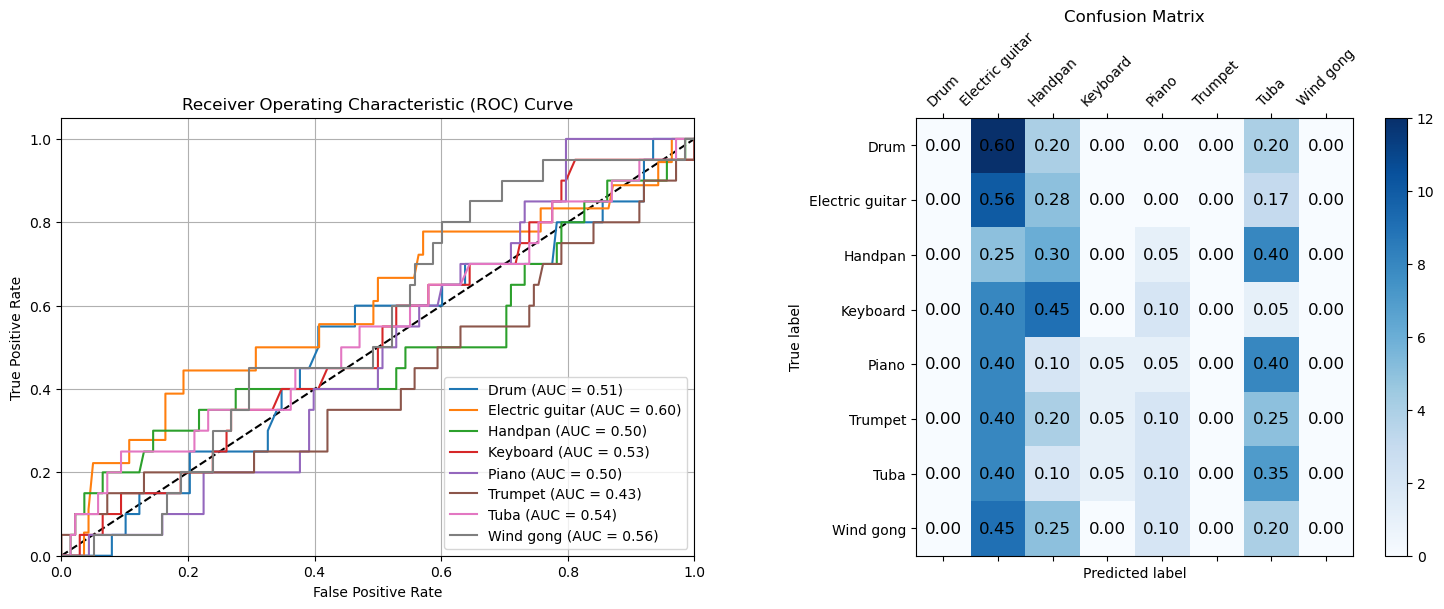


Classification Report:
                 precision    recall  f1-score   support

           Drum       0.00      0.00      0.00        20
Electric guitar       0.15      0.56      0.23        18
        Handpan       0.16      0.30      0.21        20
       Keyboard       0.00      0.00      0.00        20
          Piano       0.10      0.05      0.07        20
        Trumpet       0.00      0.00      0.00        20
           Tuba       0.17      0.35      0.23        20
      Wind gong       0.00      0.00      0.00        20

       accuracy                           0.15       158
      macro avg       0.07      0.16      0.09       158
   weighted avg       0.07      0.15      0.09       158



c:\Users\peppe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\peppe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\peppe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [104]:
evaluator(history, model, test_generator)

# Nono esperimento

Qui implementiamo uno modello CNN sulla base del primo esperimento diminuendone la complessità al fine di ridurre l'overfitting.

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization

model = Sequential()
model.add(Conv2D(64, kernel_size = (4, 4), activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation = "softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 64)      3136      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 32)                7872544   
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
Total params: 7,875,944
Trainable params: 7,875,944
Non-trainable params: 0
______________________________________________

In [5]:
history = model.fit(
    train_generator,
    epochs = 25,
    validation_data = validation_generator,
)

Epoch 1/25
19/19 [==============================] - 20s 1s/step - loss: 7.9857 - accuracy: 0.1823 - val_loss: 2.0306 - val_accuracy: 0.1417
Epoch 2/25
19/19 [==============================] - 12s 618ms/step - loss: 1.6041 - accuracy: 0.3671 - val_loss: 1.8077 - val_accuracy: 0.2875
Epoch 3/25
19/19 [==============================] - 12s 618ms/step - loss: 1.3204 - accuracy: 0.4864 - val_loss: 1.5413 - val_accuracy: 0.3958
Epoch 4/25
19/19 [==============================] - 12s 616ms/step - loss: 1.2273 - accuracy: 0.5179 - val_loss: 1.4319 - val_accuracy: 0.4458
Epoch 5/25
19/19 [==============================] - 12s 617ms/step - loss: 1.1451 - accuracy: 0.5801 - val_loss: 1.2744 - val_accuracy: 0.5500
Epoch 6/25
19/19 [==============================] - 12s 640ms/step - loss: 0.9741 - accuracy: 0.6712 - val_loss: 1.2152 - val_accuracy: 0.4917
Epoch 7/25
19/19 [==============================] - 13s 665ms/step - loss: 0.9184 - accuracy: 0.6985 - val_loss: 1.0616 - val_accuracy: 0.6708
Ep

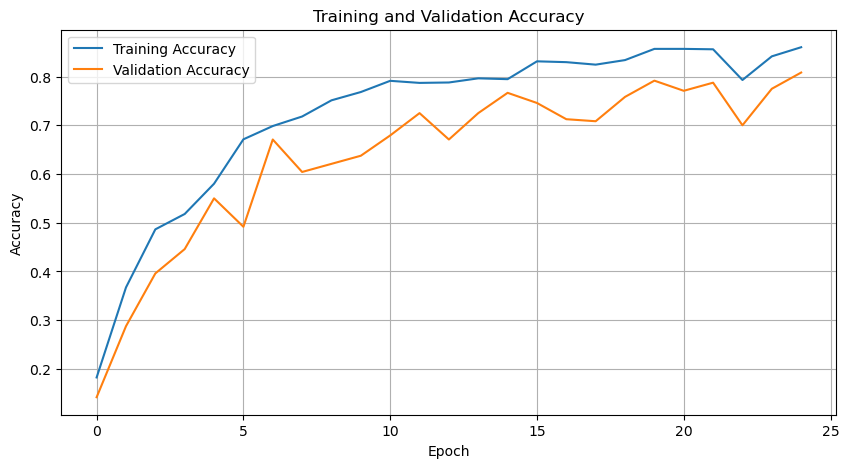

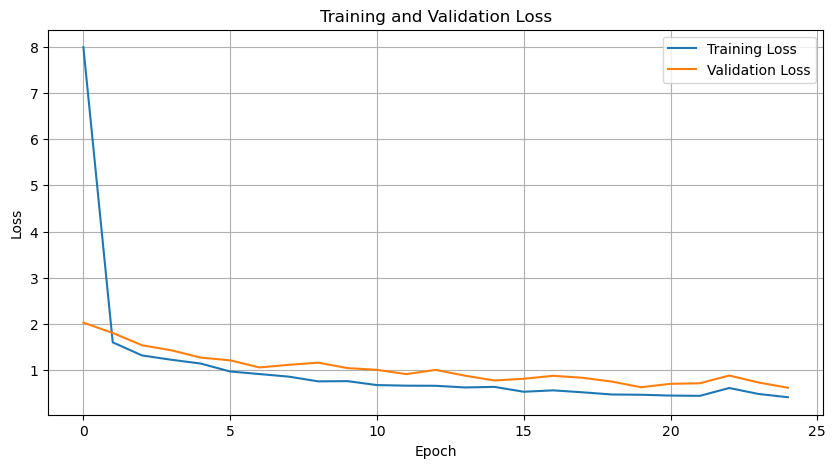

3/3 [==============================] - 1s 284ms/step


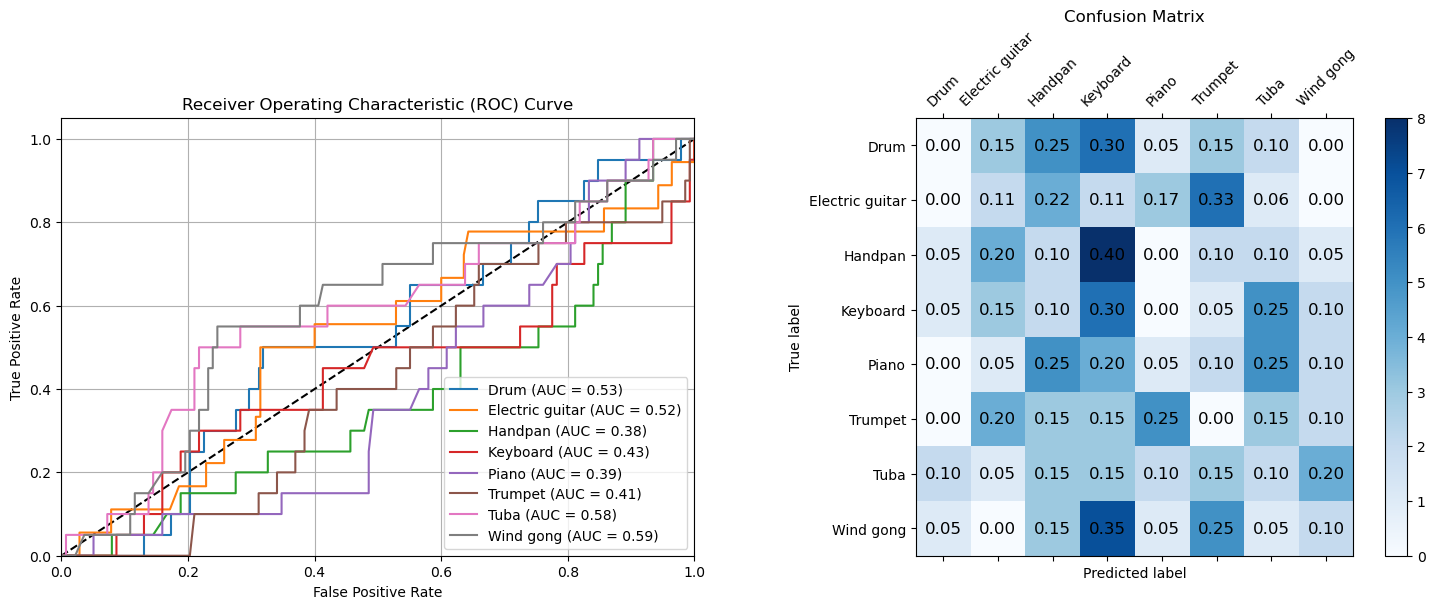


Classification Report:
                 precision    recall  f1-score   support

           Drum       0.00      0.00      0.00        20
Electric guitar       0.11      0.11      0.11        18
        Handpan       0.07      0.10      0.09        20
       Keyboard       0.15      0.30      0.20        20
          Piano       0.08      0.05      0.06        20
        Trumpet       0.00      0.00      0.00        20
           Tuba       0.10      0.10      0.10        20
      Wind gong       0.15      0.10      0.12        20

       accuracy                           0.09       158
      macro avg       0.08      0.10      0.08       158
   weighted avg       0.08      0.09      0.08       158



In [6]:
evaluator(history, model, test_generator)